# **GROUP PROJECT**

https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-74759-0_345

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import geopandas as gpd
import random
import pyproj
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
import ortools as ort
import datetime as dt
# pysal submodule imports
from pysal.lib import cg, examples
from pysal.explore import spaghetti as spgh

import geopandas as gpd
from shapely.geometry import Point
from ortools.linear_solver import pywraplp
import copy, sys, warnings
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
except ImportError:
    pass

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from ortools.sat.python import cp_model
%load_ext line_profiler

C:\Users\Noah\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# **1. FUNCTIONS**

In [2]:
def buildCityDF(nCities,gridX=100,gridY=100):
    xs = np.random.randint(0,gridX,nCities)
    ys = np.random.randint(0,gridY,nCities)
    pts = [Point(xs[i],ys[i]) for i in range(0,nCities)]
    demands = np.random.randint(0,101,nCities)
    facilityOneCosts = np.random.randint(0,101,nCities)
    facilityTwoCosts = np.random.randint(100,201,nCities)
    cityIndices = range(0,nCities)
    cities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts,"City Index":cityIndices,"Facility One Cost":facilityOneCosts,"Facility Two Cost":facilityTwoCosts})
    return cities

In [3]:
def buildDistanceMatrix_Euclidean(cities):
    distances = np.zeros((len(cities),len(cities)))
    for i,row in cities.iterrows():
        for j,row2 in cities.iterrows():
            distances[j,i] = row.geometry.distance(row2.geometry)
    return distances

In [36]:
def assignFacilitiesAndCluster(cities,M = 100,Rvz=[100000,200000],truckCapacityZ = [40000,80000],alpha=75.0,truckCapacity = 80000,fractionTruckRangeAllowed=0.8,nFacility=1,maxTimeLimit=5*60*1000):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING # SAT_INTEGER_PROGRAMMING
#     solver_instance = cp_model.CpModel()
    distances = buildDistanceMatrix_Euclidean(cities)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()
    fiz = facilityCost = cities[["Facility One Cost","Facility Two Cost"]].as_matrix()
    zRange = len(Rvz)
    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    model.set_time_limit(maxTimeLimit)
    model.SetNumThreads(4)

    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates} # which facility is served by which 
    yjz = {(j,z): model.IntVar(0,1, 'y[%i,%i]' % (j,z)) for j in range_facilityCandidates for z in range(zRange)} # charging station location decision/ concentrator
    
    obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + alpha*2*cij[0,j]*yjz[j,z] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(zRange)]
#     obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(zRange)]

    # Service Constraint
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == nFacility)
    
    # Capacity Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= model.Sum([truckCapacityZ[z]*yjz[j,z] for z in range(zRange)]))
    
    # Assignment Constraint
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= model.Sum([yjz[j,z] for z in range(zRange)]))
    
    # Maximum Concentratorrs Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for j in range_facilityCandidates for z in range(zRange)]) <= M)
        
    # Total tour length constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([xij[i,j]*cij[i,j] for i in range_facilityCandidates]) <= model.Sum([yjz[j,z]*Rvz[z]*fractionTruckRangeAllowed for z in range(zRange)]))
        
    # Z limitation constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for z in range(zRange)]) <= 1)

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    for z in range(2):
        resultGDF[f"Status: Facility Type {z}"] = [yjz[j,z].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 0"] = [yjz[j,0].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 1"] = [yjz[j,1].solution_value() for j in range_facilityCandidates]
    return model,yjz,xij,resultGDF,status

In [ ]:
def assignFacilitiesAndCluster(cities,M = 100,Rvz=[100000,200000],truckCapacityZ = [40000,80000],alpha=75.0,truckCapacity = 80000,fractionTruckRangeAllowed=0.8,nFacility=1,maxTimeLimit=5*60*1000,tourLengthViolationPenalty = 500):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
#     solver_instance = cp_model.CpModel()
    distances = buildDistanceMatrix_Euclidean(cities)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()
    fiz = facilityCost = cities[["Facility One Cost","Facility Two Cost"]].as_matrix()
    zRange = len(Rvz)
    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    model.set_time_limit(maxTimeLimit)

#     model.parameters.max_time_in_seconds = 60.0 * 5

    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates} # which facility is served by which 
    yjz = {(j,z): model.IntVar(0,1, 'y[%i,%i]' % (j,z)) for j in range_facilityCandidates for z in range(zRange)} # charging station location decision/ concentrator
    obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + alpha*2*cij[0,j]*yjz[j,z] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(zRange)]
#     tourLengthObj = [tourLengthViolationPenalty * model.Sum([yjz[j,z]*Rvz[z]-xij[i,j]*cij[i,j] for i in range_customers for z in range(zRange)]) for j in range_customers]
#     tourLengthObj = [tourLengthViolationPenalty * yjz[j,0]*Rvz[0]+yjz[j,1]*Rvz[1]-xij[i,j]*cij[i,j] for i in range_customers for j in range_facilityCandidates]
#     obj = obj.extend(tourLengthObj)
    obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + alpha*2*cij[0,j]*yjz[j,z] + fiz[i,z] * yjz[j,z] + tourLengthViolationPenalty * (yjz[j,0]*Rvz[0]+yjz[j,1]*Rvz[1]-xij[i,j]*cij[i,j]) for i in range_customers for j in range_facilityCandidates for z in range(zRange)]

    # Service Constraint
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == nFacility)
    
    # Capacity Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= model.Sum([truckCapacityZ[z]*yjz[j,z] for z in range(zRange)]))
    
    # Assignment Constraint
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= model.Sum([yjz[j,z] for z in range(zRange)]))
    
    # Maximum Concentratorrs Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for j in range_facilityCandidates for z in range(zRange)]) <= M)
        
    # Total tour length constraint
#     for j in range_facilityCandidates:
#         model.Add(model.Sum([xij[i,j]*cij[i,j] for i in range_facilityCandidates]) <= model.Sum([yjz[j,z]*Rvz[z]*fractionTruckRangeAllowed for z in range(zRange)]))
        
    # Z limitation constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for z in range(zRange)]) <= 1)

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    for z in range(2):
        resultGDF[f"Status: Facility Type {z}"] = [yjz[j,z].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 0"] = [yjz[j,0].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 1"] = [yjz[j,1].solution_value() for j in range_facilityCandidates]
    return model,yjz,xij,resultGDF,status

In [6]:
def convertTourToPathDF(tour,resultGDF):
#     tour = list(resultGDF[resultGDF["assignment"]==tour]["City Index"])
    tour.append(tour[0]) # Return to end
    startNodes = []
    endNodes = []
    startCoords = []
    endCoords = []
    lines = [] # https://gis.stackexchange.com/questions/95670/how-to-create-a-shapely-linestring-from-two-points
    for i in range(0,len(tour)):
        currentCity = tour[i]
        if i < len(tour)-1:
            nextCity = tour[i+1]
        else:
            nextCity = tour[0]
        startNodes.append(currentCity)
        endNodes.append(nextCity)
        startPoint = resultGDF[resultGDF["City Index"]==currentCity].geometry
        startCoords.append(startPoint)
        endPoint = resultGDF[resultGDF["City Index"]==nextCity].geometry
        endCoords.append(endPoint)
        line = LineString([(startPoint.x,startPoint.y),(endPoint.x,endPoint.y)])
        lines.append(line)
    gdf = gpd.GeoDataFrame({"Start Node":startNodes,"End Node":endNodes,"geometry":lines})
    return gdf

In [7]:
# https://developers.google.com/optimization/routing/tsp
"""Simple travelling salesman problem between cities."""

def create_data_model(dfSubset):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = buildDistanceMatrix_Euclidean(dfSubset.reset_index())
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data


def print_solution(manager, routing, assignment,dfSubset):
    """Prints assignment on console."""
    optimizedRoute = []
#     print(f"Objective: ")
#     print('Objective: {} meters'.format(assignment.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    orderedDFSubset = dfSubset.reset_index()
    while not routing.IsEnd(index):
        correctedCityIndex = orderedDFSubset.iloc[manager.IndexToNode(index)][0]
        optimizedRoute.append(correctedCityIndex)
#         print(f"******{correctedCityIndex}")
#         print(f"====>{orderedDFSubset.iloc[manager.IndexToNode(index)]}")
#         plan_output += ' {} ->'.format(manager.IndexToNode(index))
        plan_output += ' {} ->'.format(correctedCityIndex)

        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
#     plan_output += ' {}\n'.format(manager.IndexToNode(index))
    correctedCityIndex = orderedDFSubset.iloc[manager.IndexToNode(index)][0]
    plan_output += ' {}\n'.format(correctedCityIndex)
#     print(f"******{correctedCityIndex}")
    optimizedRoute.append(correctedCityIndex)
#     print(f"====>{orderedDFSubset.iloc[manager.IndexToNode(index)]}")
    plan_output += f'Route distance: {route_distance/1000.0} km\n'
    print(plan_output)
    return optimizedRoute,route_distance


def main(dfSubset):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(dfSubset)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        route,route_distance = print_solution(manager, routing, assignment,dfSubset)
    return route,route_distance

In [47]:
def solveAndPlot(illinoisCities,M=20,Rvz=[200000,400000],truckCapacityZ = [40000,80000],alpha=0.001,fractionTruckRangeAllowed=0.75,maxTimeLimit=5*60*1000):
    parameterString = f"{len(illinoisCities)} Cities, M={M}, Alpha: {alpha}, fractionTruckRangeAllowed: {fractionTruckRangeAllowed}, Time Limit: {maxTimeLimit/60/1000} Minutes\nVehicle 1 Range: {Rvz[0]}, Vehicle 2 Range: {Rvz[1]}, Vehicle 1 Capacity: {truckCapacityZ[0]}, Vehicle 2 Capacity: {truckCapacityZ[1]}"
    model,yjz,xij,resultGDF,status = assignFacilitiesAndCluster(illinoisCities,M=M,Rvz=Rvz,truckCapacityZ=truckCapacityZ,alpha=alpha,fractionTruckRangeAllowed=fractionTruckRangeAllowed,maxTimeLimit=maxTimeLimit)
    assignments = np.zeros((nCities,nCities))
    for k,v in xij.items():
        i = k[0]
        j = k[1]
        assignments[i,j] = v.solution_value()
    cluster = []
    for cityNodeID in range(nCities):
        for rootNodeID in range(nCities):
            lookup = assignments[cityNodeID,rootNodeID]
            if lookup == 1:
                cluster.append(rootNodeID)
    resultGDF["assignment"] = cluster
    uniqueClusters = list(set(cluster))


    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    fig.tight_layout()

    illinois.plot(ax=ax1,color="blue",alpha=0.1)
    illinois.sort_values("ALAND",ascending=False).reset_index()[0:nCities].plot(ax=ax1,color="red",alpha=0.2)
    # illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax1,color="white",marker='*')

    colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
    totalCost = 0.0
    subtourRoutingCosts = {}
    subtourConstructionCosts = {}
    subtourDistances = {}
    totalConstructionCost = np.sum(resultGDF["Facility One Cost"] * resultGDF["Status: Facility Type 0"] + resultGDF["Facility Two Cost"] * resultGDF["Status: Facility Type 1"])
    for i in range(0,len(uniqueClusters)):
        dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
        tour,tourLength = main(dfSubset)
        if resultGDF.iloc[uniqueClusters[i]]["Status: Facility Type 0"]==1:
            facilityType = 0
            vehicleType = "Standard range"
        else:
            facilityType = 1
            vehicleType = "Extended range"
        subtourRoutingCosts[i] = alpha * tourLength
        subtourDistances[i] = tourLength
        # check if constraint violated
        label = f"{resultGDF.iloc[uniqueClusters[i]].Name}: {tourLength/1000:,.0f} KM, {vehicleType} vehicle"
        if tourLength > Rvz[facilityType]:
            label += " CONSTRAINT VIOLATED"
        # plot the nodes
        dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"]/100,label=label)
        # plot the tour
        ls = "dashed"
        if facilityType == 1:
            ls = "dotted"
        convertTourToPathDF(tour,resultGDF).plot(ax=ax1,colors=colors[i],ls=ls,alpha=0.75)
        # plot the facilities
        dfFacility = resultGDF[resultGDF["City Index"]==uniqueClusters[i]]
        dfFacility.plot(ax=ax1,markersize=1000,marker="o",alpha=.75,facecolors='none', edgecolors=colors[i])
    totalRoutingCost = np.sum(list(subtourRoutingCosts.values()))
    totalRoutingDistance = np.sum(list(subtourDistances.values()))
    f""
    ax1.set_title(f"Tours organized by cluster\nNode sizes proportional to demand\nConstruction Cost: ${totalConstructionCost:,.2f}, Routing Distance: {totalRoutingDistance/1000:,.0f} KM\n$Total Cost: {totalConstructionCost + totalRoutingCost:,.2f}\n{parameterString}")
    ax1.legend()
    # Plot assignments
    plt.imshow(assignments)
    ax2.set_title("Assignment of citites to subtours")
    ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
    ax2.set_ylabel("City")

# **2. SET UP CITIES**

In [62]:
illinoisCitiesPath = "Final Presentation\\tl_2016_17_place\\tl_2016_17_place.shp"
illinoisCitiesPath = "Final Presentation\\illinois_projected.shp"
illinois = gpd.read_file(illinoisCitiesPath)

In [82]:
nCities = 40
facilityOneBaseCost = 100000
facilityOneBaseSTD = 10000
facilityTwoBaseCost = 1000000
facilityTwoBaseSTD = 100000
baseDemand = 10000
baseDemandSTD = 10000
demands = np.random.normal(baseDemand, baseDemandSTD, nCities)
demands = [np.abs(demand) for demand in demands]
facilityOneCosts = np.random.normal(facilityOneBaseCost, facilityOneBaseSTD, nCities)
facilityOneCosts = [np.abs(facilityOneCost) for facilityOneCost in facilityOneCosts]
facilityTwoCosts = np.random.normal(facilityTwoBaseCost, facilityTwoBaseSTD, nCities)
facilityTwoCosts = [np.abs(facilityTwoCost) for facilityTwoCost in facilityTwoCosts]
cityIndices = range(nCities)
xs = []
ys = []
pts = []
polygons = []
cityNames = []
illinoisGeoms = illinois.sort_values("ALAND",ascending=False).reset_index()
for i,row in illinoisGeoms[0:nCities].iterrows():
    pts.append(row["geometry"].centroid)
    polygons.append(row["geometry"])
    xs.append(row["geometry"].centroid.x)
    ys.append(row["geometry"].centroid.y)
    cityNames.append(row["NAME"])


illinoisCities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts,"polygon":polygons,"City Index":cityIndices,"Facility One Cost":facilityOneCosts,"Facility Two Cost":facilityTwoCosts,"Name":cityNames})

In [83]:
dfData = pd.read_excel("Facilities Cost.xlsx")

In [84]:
illinoisCities[["Population","demand","Unit Land Cost","Facility One Cost","Facility Two Cost"]] = dfData[["Population","Demand","Until Land-Price","Facility-1","Facility-2"]]

In [85]:
illinoisCities

,x,y,demand,geometry,polygon,City Index,Facility One Cost,Facility Two Cost,Name,Population,Unit Land Cost
0,-9.761033e+06,5.136620e+06,53911.96,POINT (-9761032.643654963 5136619.851659001),POLYGON ((-9789447.915200001 5161119.332400002...,0,5761625,6303625,Chicago,2695598,241
1,-9.812818e+06,5.089202e+06,2948.66,POINT (-9812817.852492342 5089202.112337102),(POLYGON ((-9836391.464600001 5094605.00670000...,1,3328250,3870250,Joliet,147433,138
2,-9.914625e+06,5.199910e+06,3057.42,POINT (-9914624.606907682 5199910.159028099),(POLYGON ((-9901115.537900001 5202313.51709999...,2,2052500,2594500,Rockford,152871,84
3,-9.980241e+06,4.832799e+06,2325.00,POINT (-9980240.949010463 4832798.992934125),(POLYGON ((-9990763.348999999 4836718.88620000...,3,2454125,2996125,Springfield,116250,101
4,-9.975938e+06,4.975814e+06,2300.14,POINT (-9975937.664920764 4975813.53921454),POLYGON ((-9985214.414999999 4979468.273800001...,4,2052500,2594500,Peoria,115007,84
5,-9.828415e+06,5.125664e+06,3957.98,POINT (-9828414.878063975 5125664.28168854),"(POLYGON ((-9819460.5472 5132383.862199999, -9...",5,3186500,3728500,Aurora,197899,132
6,-9.900056e+06,4.844982e+06,1522.44,POINT (-9900056.07244744 4844982.389529885),"(POLYGON ((-9895022.2151 4846048.145900004, -9...",6,2123375,2665375,Decatur,76122,87
7,-9.814553e+06,5.123351e+06,2837.06,POINT (-9814553.103840169 5123350.544294744),(POLYGON ((-9811223.013599999 5130011.47640000...,7,4367750,4909750,Naperville,141853,182
8,-9.832036e+06,5.166747e+06,2163.76,POINT (-9832035.636831645 5166746.83408088),"(POLYGON ((-9822604.1018 5166697.169200003, -9...",8,3824375,4366375,Elgin,108188,159
9,-1.004278e+07,4.715692e+06,359.64,POINT (-10042782.08002698 4715691.713624574),"POLYGON ((-10049480.2696 4711757.696000002, -1...",9,3257375,3799375,Godfrey,17982,135


# **3. SOLVE TSP SUB-TOURS**

In [ ]:
solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[20000,80000],alpha=0.1,fractionTruckRangeAllowed=0.85,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 2 -> 37 -> 23 -> 13 -> 31 -> 34 -> 25 -> 19 -> 11 -> 8 -> 32 -> 2
Route distance: 349.371 km

Route for vehicle 0:
 4 -> 21 -> 29 -> 33 -> 35 -> 4
Route distance: 351.464 km

Route for vehicle 0:
 3 -> 6 -> 16 -> 28 -> 10 -> 3
Route distance: 524.09 km

Route for vehicle 0:
 0 -> 38 -> 39 -> 1 -> 27 -> 20 -> 5 -> 7 -> 14 -> 12 -> 26 -> 17 -> 18 -> 0
Route distance: 582.165 km

Route for vehicle 0:
 9 -> 22 -> 36 -> 30 -> 15 -> 24 -> 9
Route distance: 469.718 km



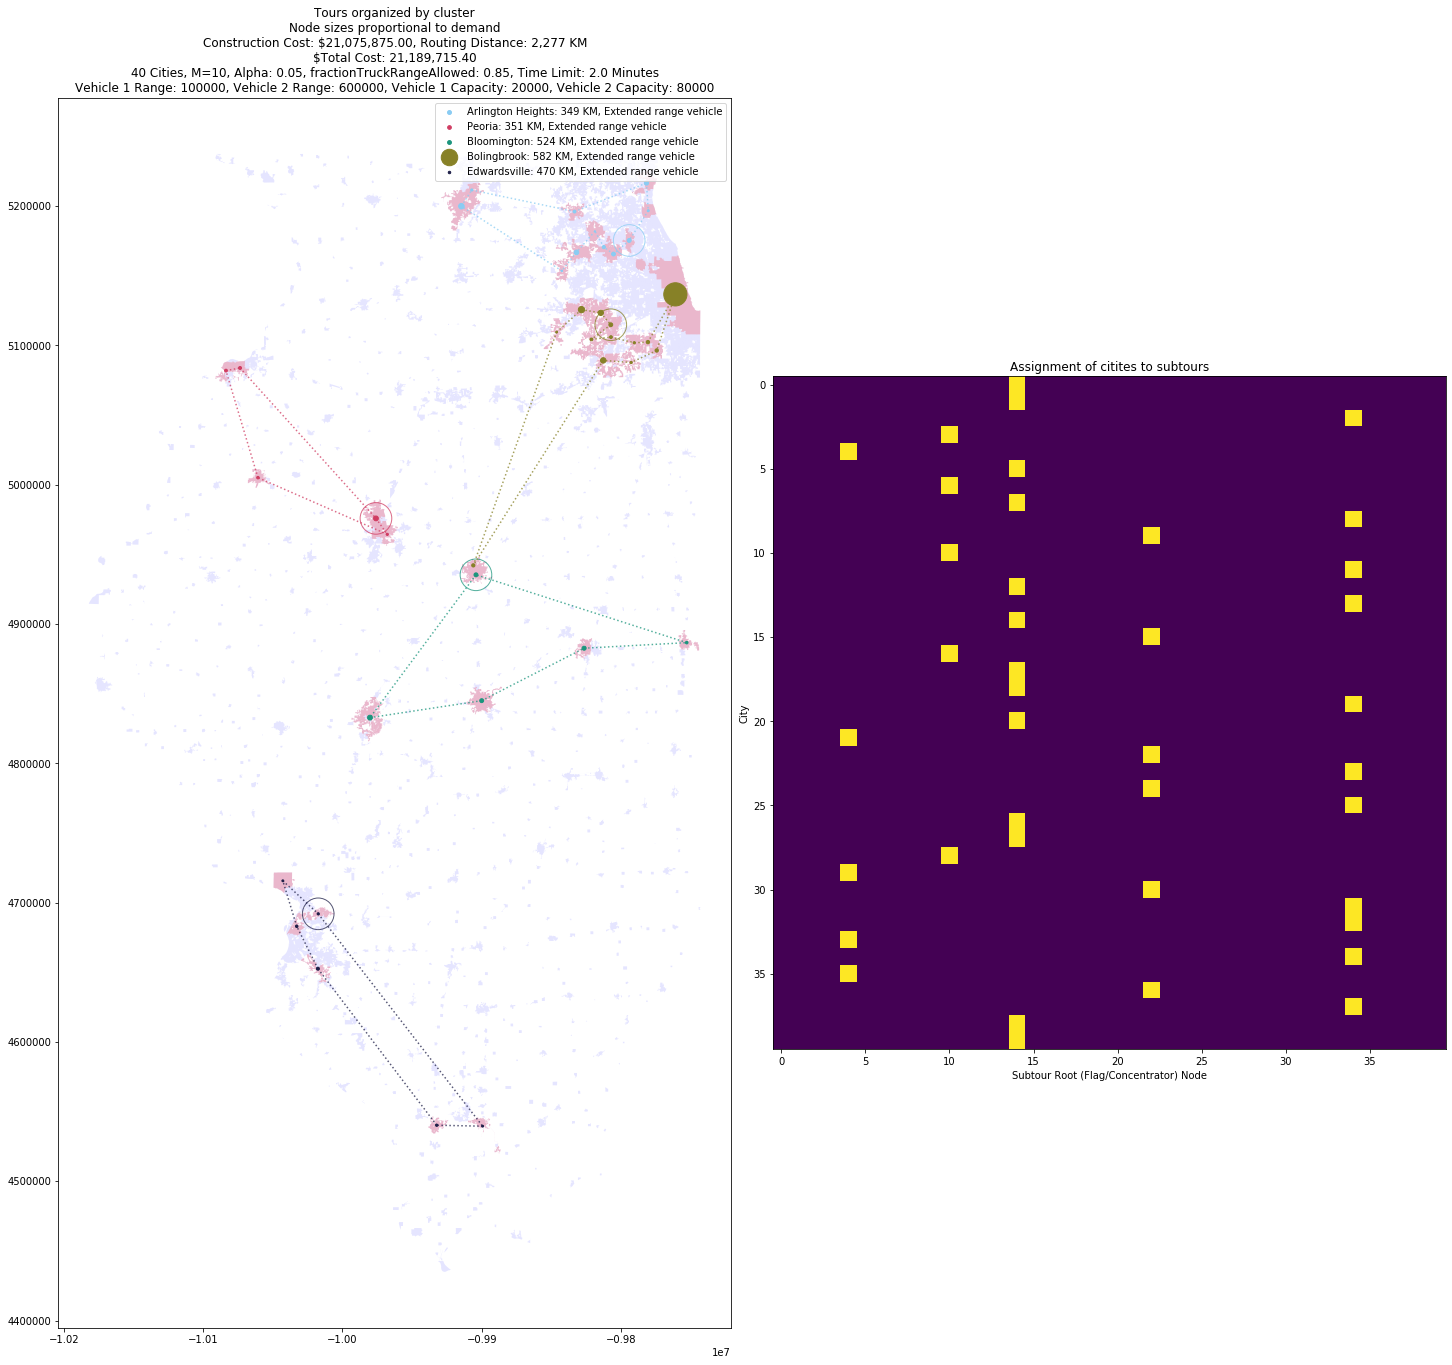

In [91]:
solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[20000,80000],alpha=0.05,fractionTruckRangeAllowed=0.85,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 2 -> 37 -> 23 -> 13 -> 31 -> 34 -> 25 -> 19 -> 11 -> 8 -> 2
Route distance: 335.674 km

Route for vehicle 0:
 0 -> 38 -> 18 -> 17 -> 39 -> 1 -> 12 -> 26 -> 14 -> 7 -> 5 -> 20 -> 32 -> 0
Route distance: 312.286 km

Route for vehicle 0:
 9 -> 22 -> 36 -> 30 -> 15 -> 24 -> 9
Route distance: 469.718 km

Route for vehicle 0:
 6 -> 16 -> 28 -> 10 -> 27 -> 21 -> 6
Route distance: 525.202 km

Route for vehicle 0:
 3 -> 4 -> 35 -> 33 -> 29 -> 3
Route distance: 569.189 km



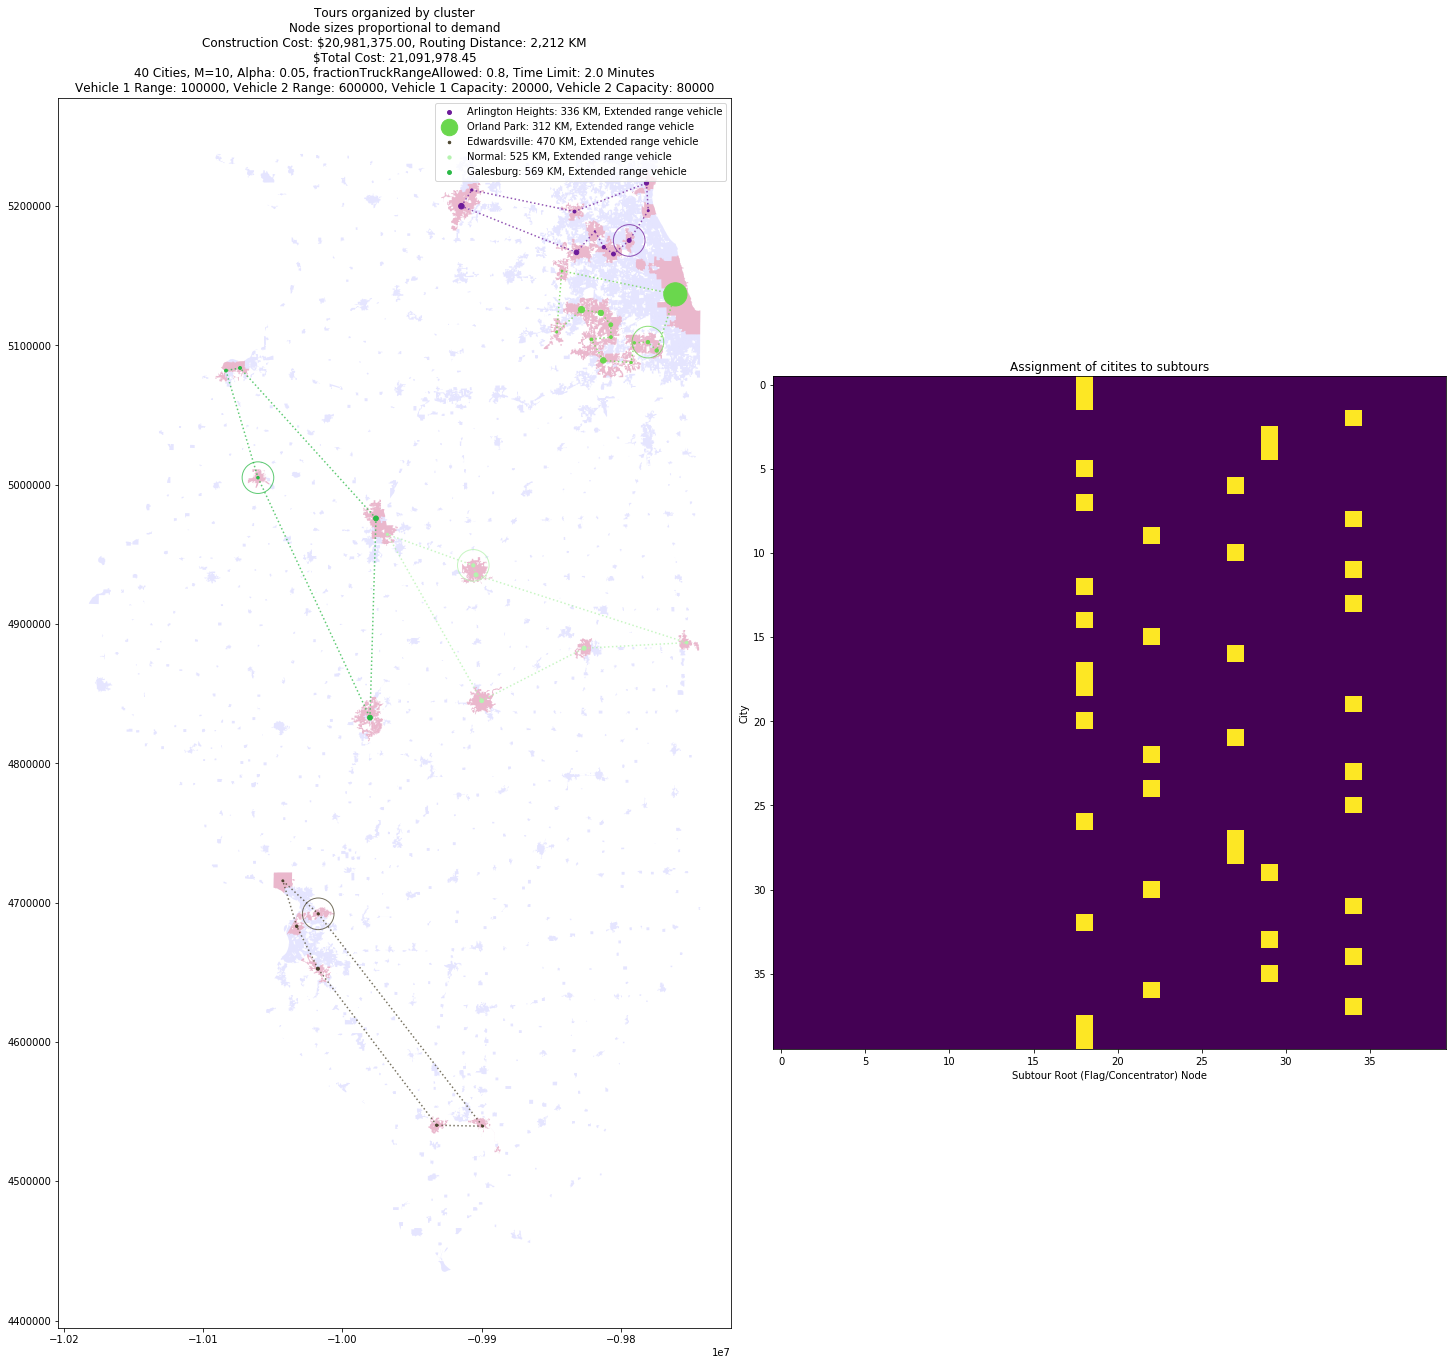

In [90]:
solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[20000,80000],alpha=0.05,fractionTruckRangeAllowed=0.8,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 4 -> 21 -> 29 -> 33 -> 35 -> 4
Route distance: 351.464 km

Route for vehicle 0:
 30 -> 36 -> 30
Route distance: 65.956 km

Route for vehicle 0:
 3 -> 9 -> 24 -> 15 -> 22 -> 3
Route distance: 385.905 km

Route for vehicle 0:
 2 -> 23 -> 13 -> 31 -> 34 -> 25 -> 19 -> 11 -> 8 -> 5 -> 32 -> 2
Route distance: 397.013 km

Route for vehicle 0:
 0 -> 38 -> 18 -> 17 -> 39 -> 1 -> 26 -> 14 -> 7 -> 12 -> 20 -> 37 -> 0
Route distance: 461.821 km

Route for vehicle 0:
 6 -> 16 -> 28 -> 27 -> 10 -> 6
Route distance: 416.773 km



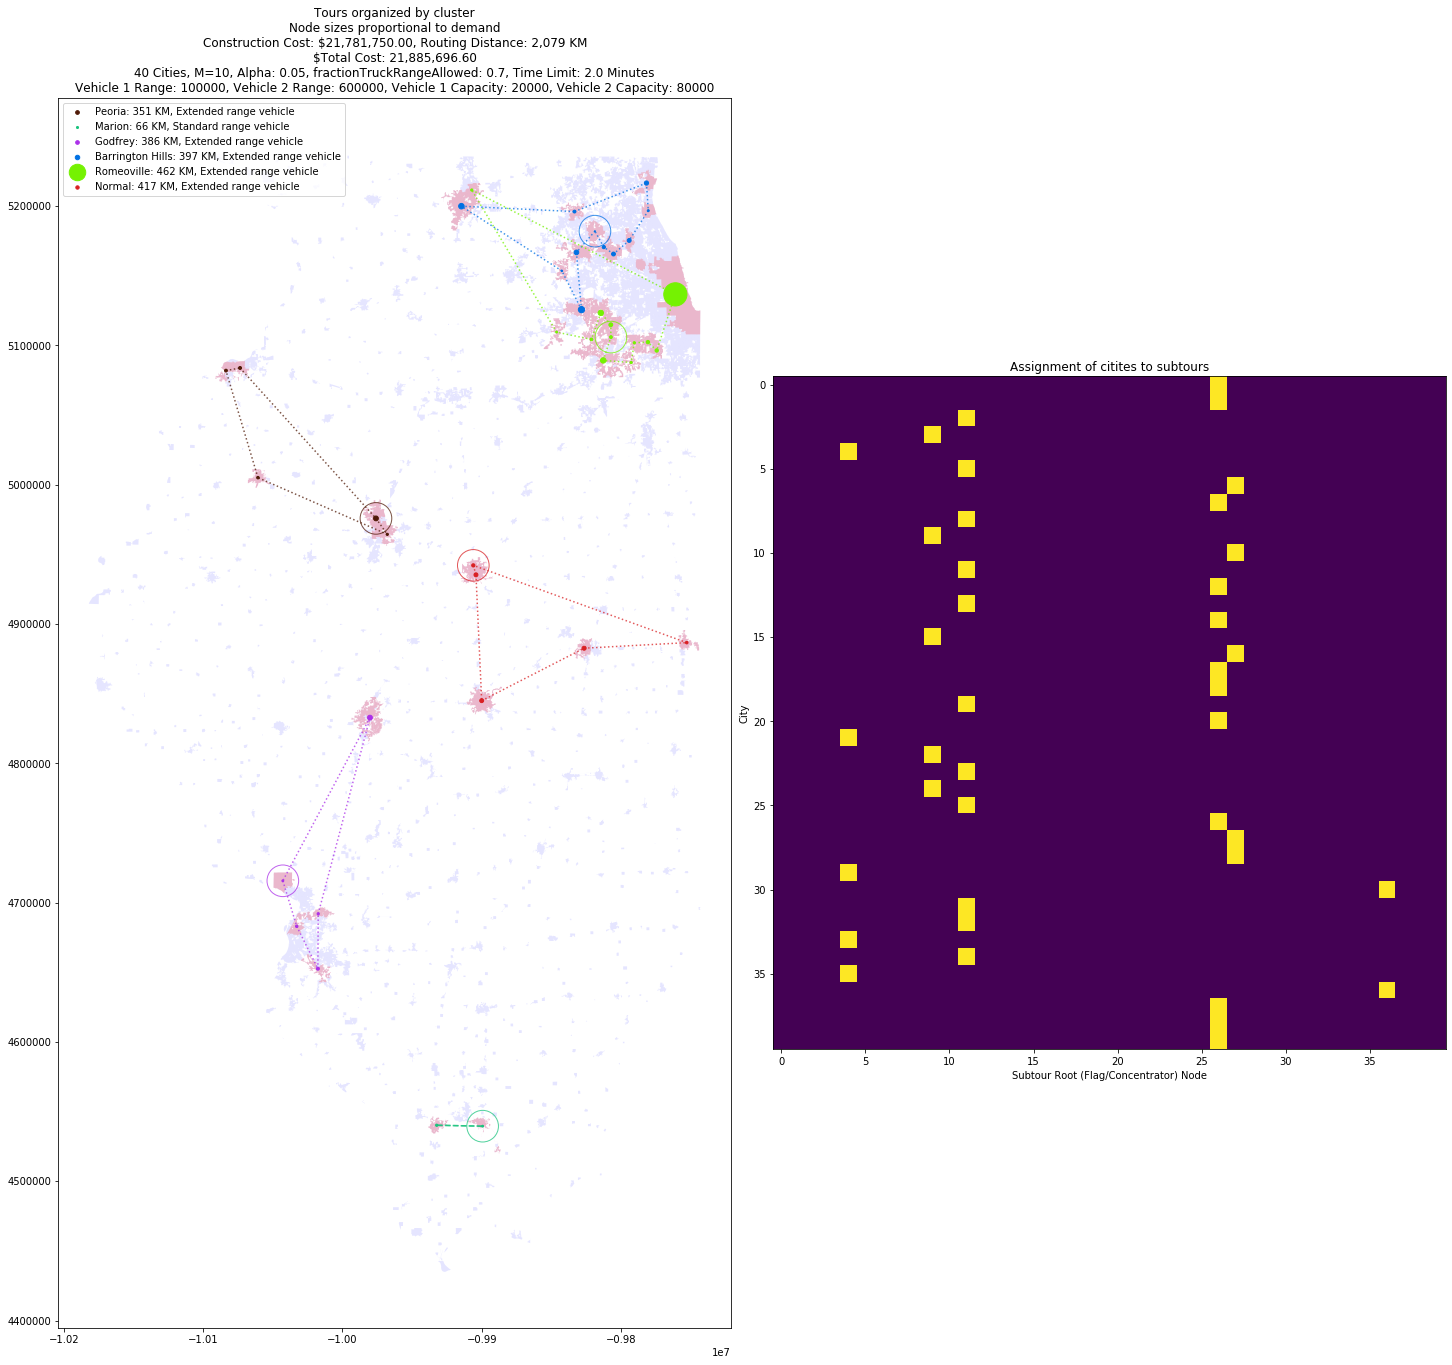

In [89]:
solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[20000,80000],alpha=0.05,fractionTruckRangeAllowed=0.7,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 30 -> 36 -> 30
Route distance: 65.956 km

Route for vehicle 0:
 6 -> 16 -> 28 -> 27 -> 10 -> 6
Route distance: 416.773 km

Route for vehicle 0:
 2 -> 37 -> 23 -> 13 -> 31 -> 25 -> 19 -> 11 -> 8 -> 2
Route distance: 335.282 km

Route for vehicle 0:
 17 -> 18 -> 38 -> 39 -> 17
Route distance: 53.105 km

Route for vehicle 0:
 3 -> 9 -> 24 -> 15 -> 22 -> 3
Route distance: 385.905 km

Route for vehicle 0:
 0 -> 34 -> 32 -> 5 -> 20 -> 12 -> 1 -> 26 -> 14 -> 7 -> 0
Route distance: 294.848 km

Route for vehicle 0:
 4 -> 21 -> 29 -> 33 -> 35 -> 4
Route distance: 351.464 km



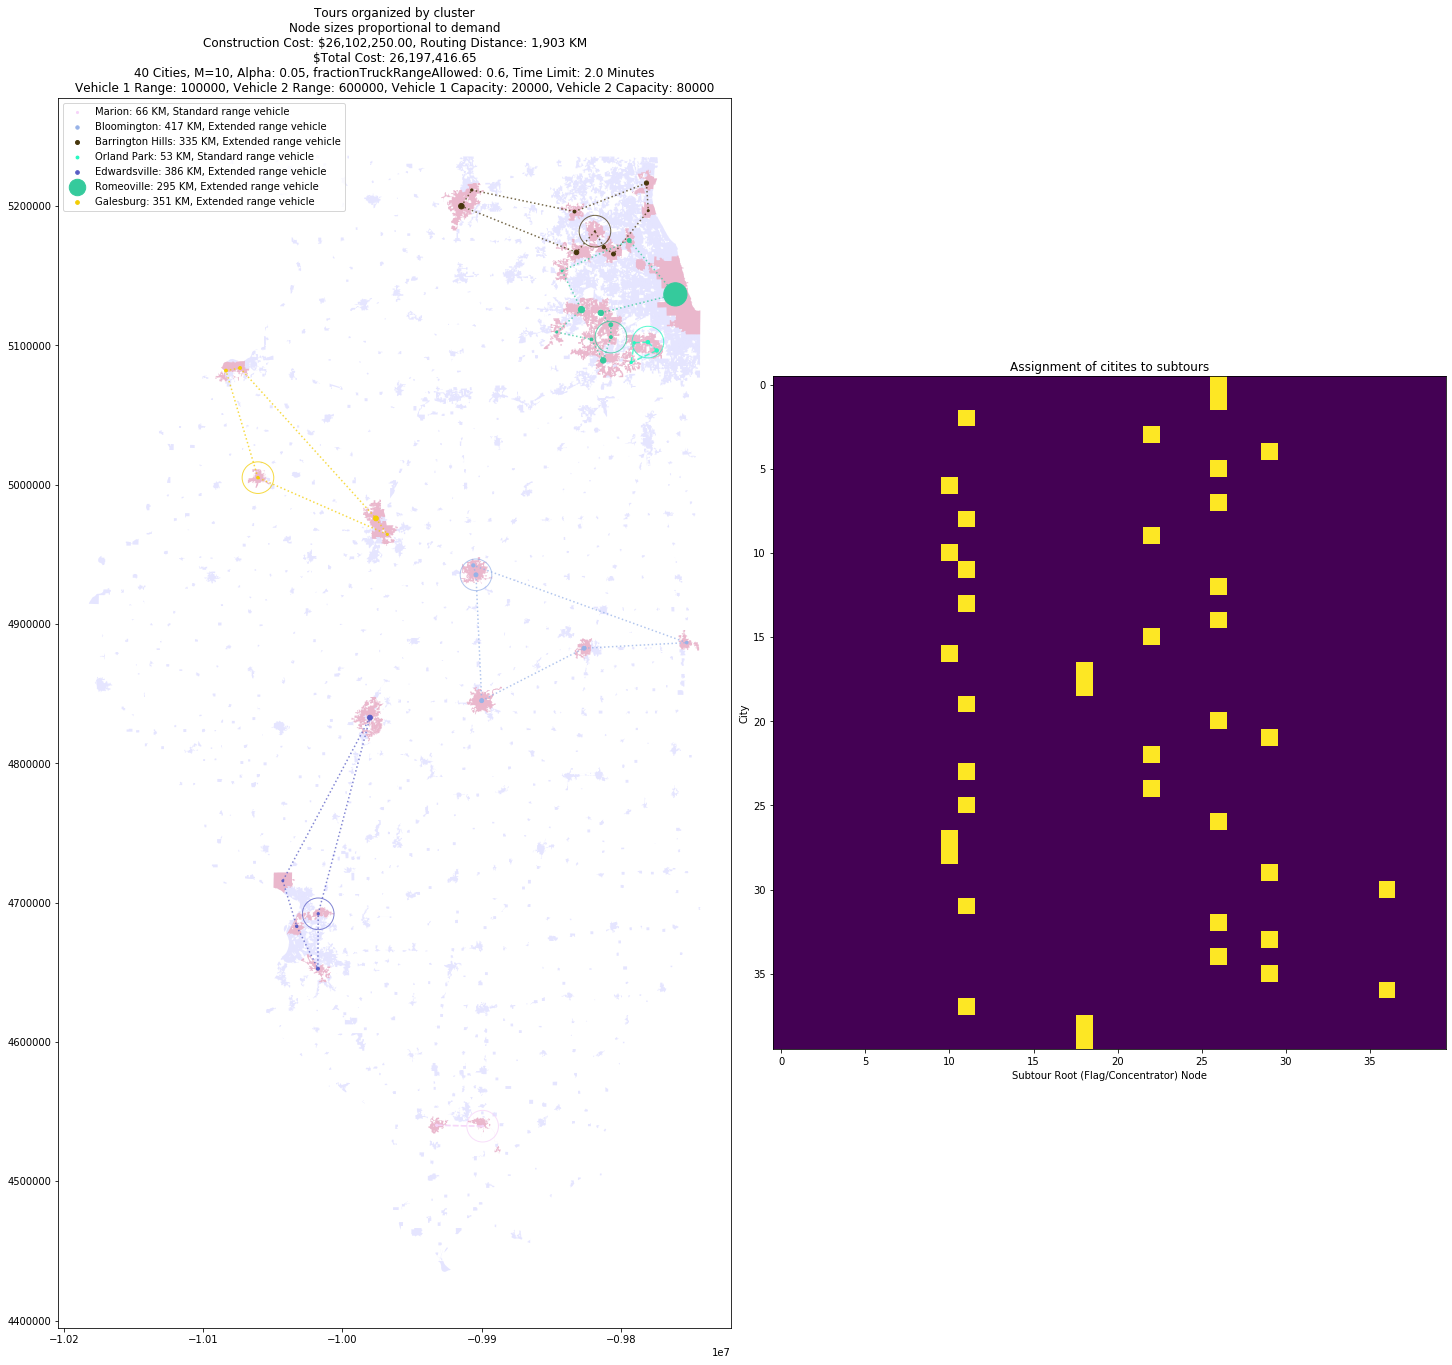

In [88]:
solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[20000,80000],alpha=0.05,fractionTruckRangeAllowed=0.6,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 6 -> 16 -> 28 -> 27 -> 10 -> 6
Route distance: 416.773 km

Route for vehicle 0:
 8 -> 32 -> 37 -> 23 -> 13 -> 31 -> 34 -> 25 -> 19 -> 11 -> 8
Route distance: 336.684 km

Route for vehicle 0:
 3 -> 9 -> 24 -> 15 -> 22 -> 3
Route distance: 385.905 km

Route for vehicle 0:
 17 -> 39 -> 38 -> 17
Route distance: 51.615 km

Route for vehicle 0:
 0 -> 18 -> 1 -> 12 -> 26 -> 14 -> 7 -> 5 -> 20 -> 2 -> 0
Route distance: 443.181 km

Route for vehicle 0:
 4 -> 21 -> 29 -> 33 -> 35 -> 4
Route distance: 351.464 km

Route for vehicle 0:
 30 -> 36 -> 30
Route distance: 65.956 km



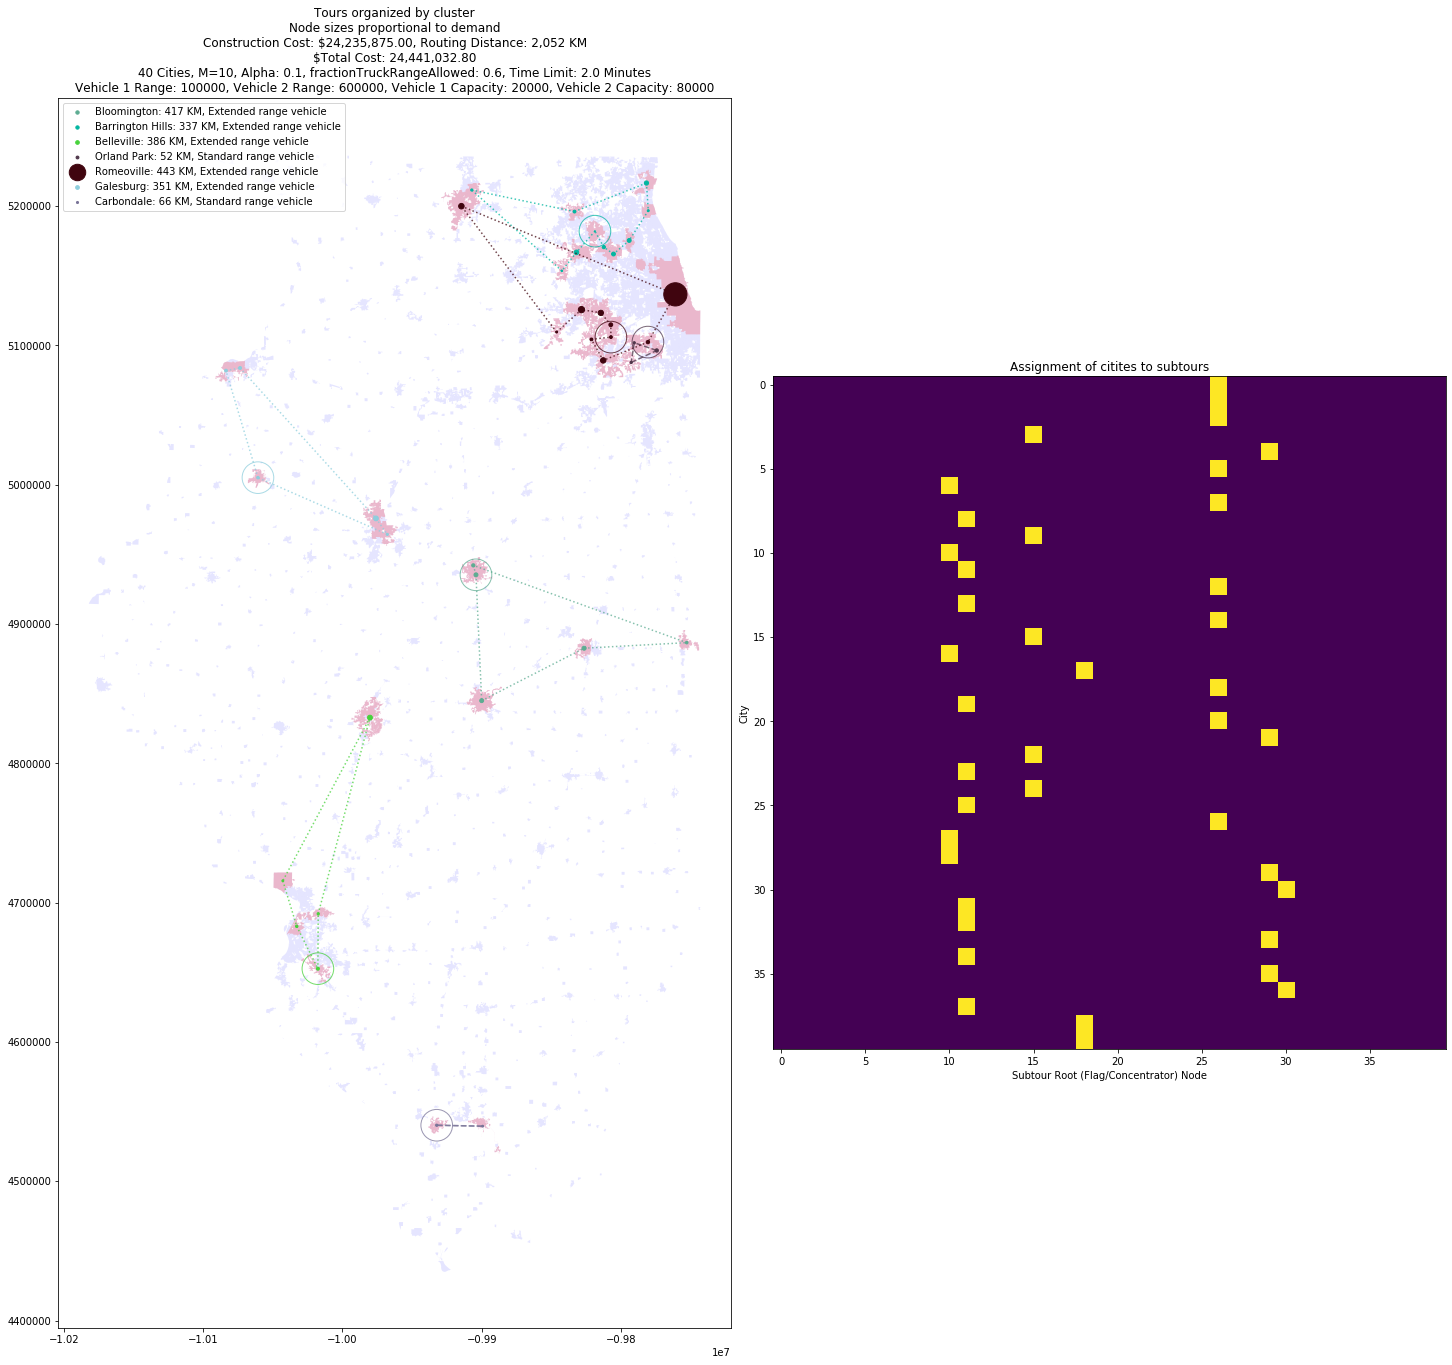

In [87]:
solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[20000,80000],alpha=0.1,fractionTruckRangeAllowed=0.6,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 4 -> 21 -> 29 -> 33 -> 35 -> 4
Route distance: 351.464 km

Route for vehicle 0:
 3 -> 6 -> 16 -> 10 -> 27 -> 3
Route distance: 396.662 km

Route for vehicle 0:
 2 -> 23 -> 13 -> 31 -> 34 -> 25 -> 19 -> 11 -> 8 -> 7 -> 32 -> 2
Route distance: 412.476 km

Route for vehicle 0:
 9 -> 22 -> 30 -> 15 -> 24 -> 9
Route distance: 417.923 km

Route for vehicle 0:
 0 -> 38 -> 18 -> 17 -> 39 -> 1 -> 12 -> 26 -> 14 -> 5 -> 20 -> 37 -> 0
Route distance: 466.445 km

Route for vehicle 0:
 28 -> 36 -> 28
Route distance: 753.45 km



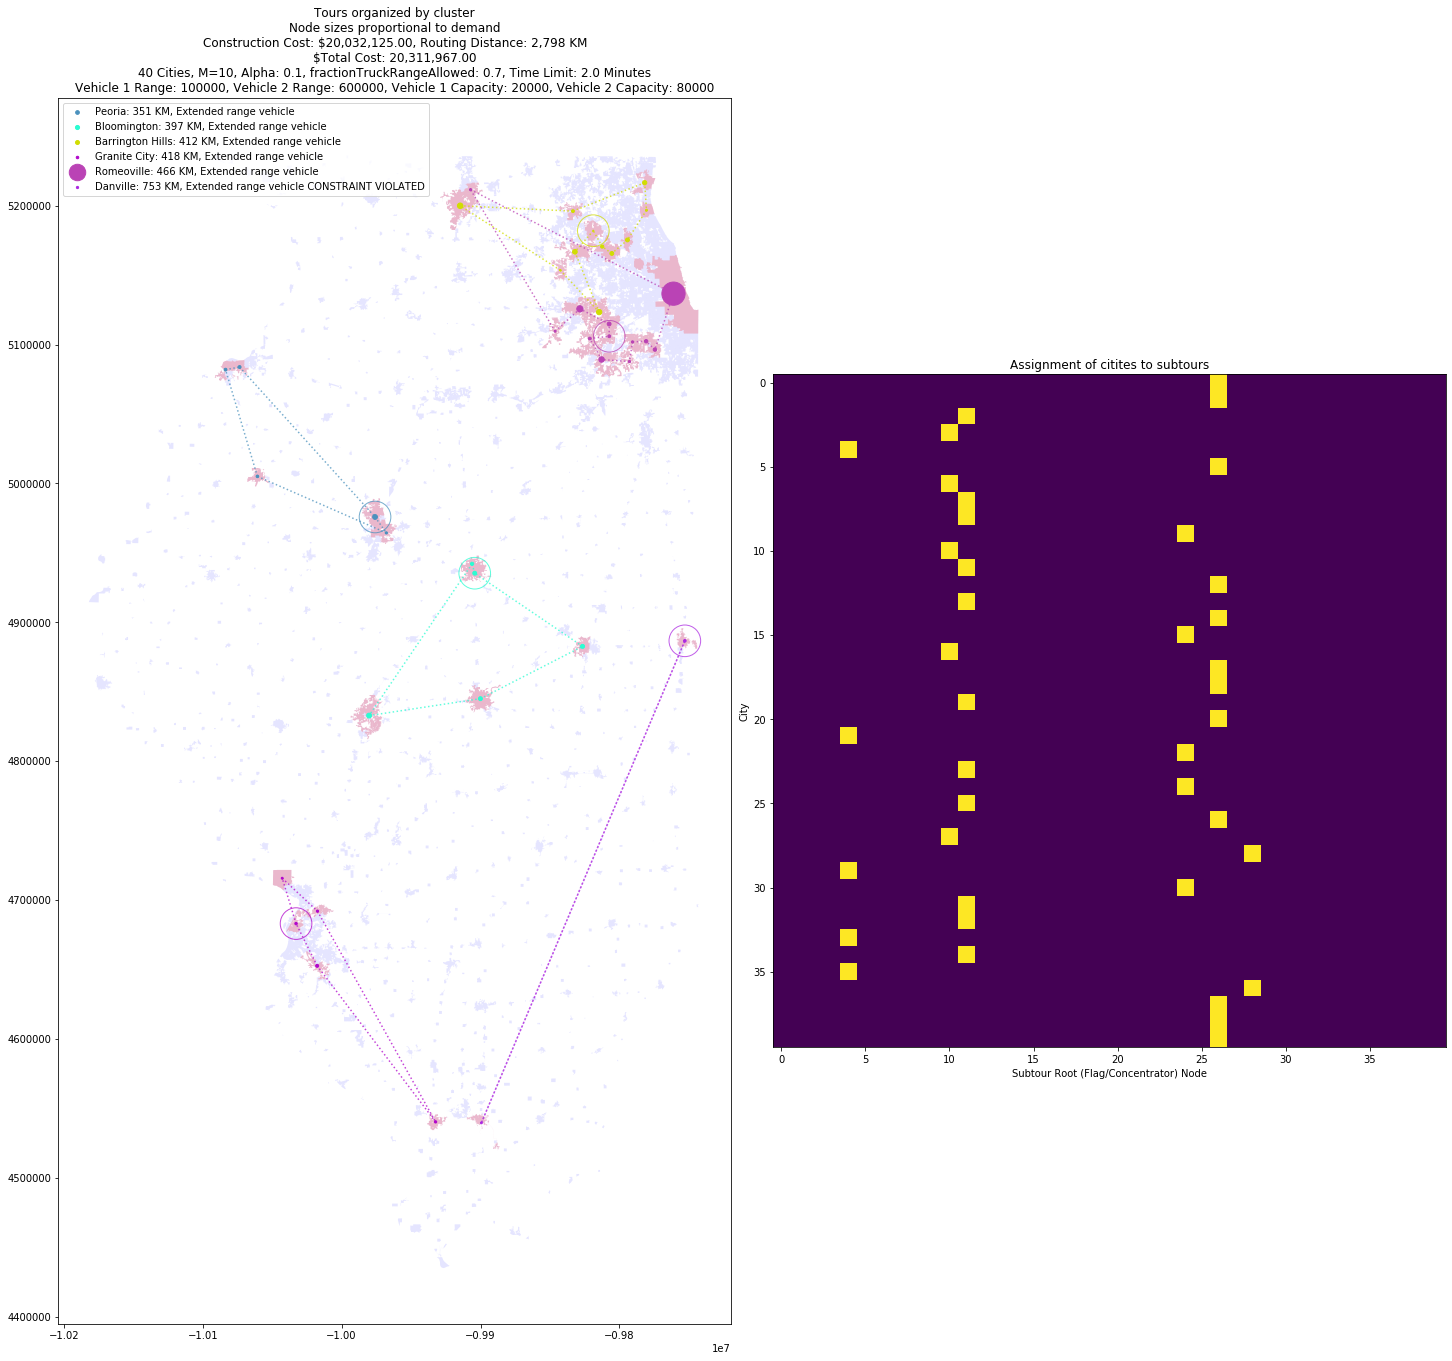

In [86]:
solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[20000,80000],alpha=0.1,fractionTruckRangeAllowed=0.7,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 2 -> 43 -> 32 -> 8 -> 11 -> 31 -> 13 -> 23 -> 2
Route distance: 332.548 km

Route for vehicle 0:
 33 -> 35 -> 33
Route distance: 20.614 km

Route for vehicle 0:
 3 -> 29 -> 40 -> 3
Route distance: 569.66 km

Route for vehicle 0:
 30 -> 36 -> 30
Route distance: 65.956 km

Route for vehicle 0:
 9 -> 42 -> 22 -> 9
Route distance: 69.529 km

Route for vehicle 0:
 1 -> 26 -> 14 -> 7 -> 5 -> 41 -> 37 -> 20 -> 49 -> 12 -> 48 -> 1
Route distance: 385.21 km

Route for vehicle 0:
 0 -> 18 -> 17 -> 39 -> 47 -> 28 -> 46 -> 38 -> 0
Route distance: 523.059 km

Route for vehicle 0:
 15 -> 44 -> 24 -> 15
Route distance: 78.29 km

Route for vehicle 0:
 19 -> 34 -> 25 -> 45 -> 19
Route distance: 85.962 km

Route for vehicle 0:
 4 -> 21 -> 6 -> 16 -> 10 -> 27 -> 4
Route distance: 412.365 km

 

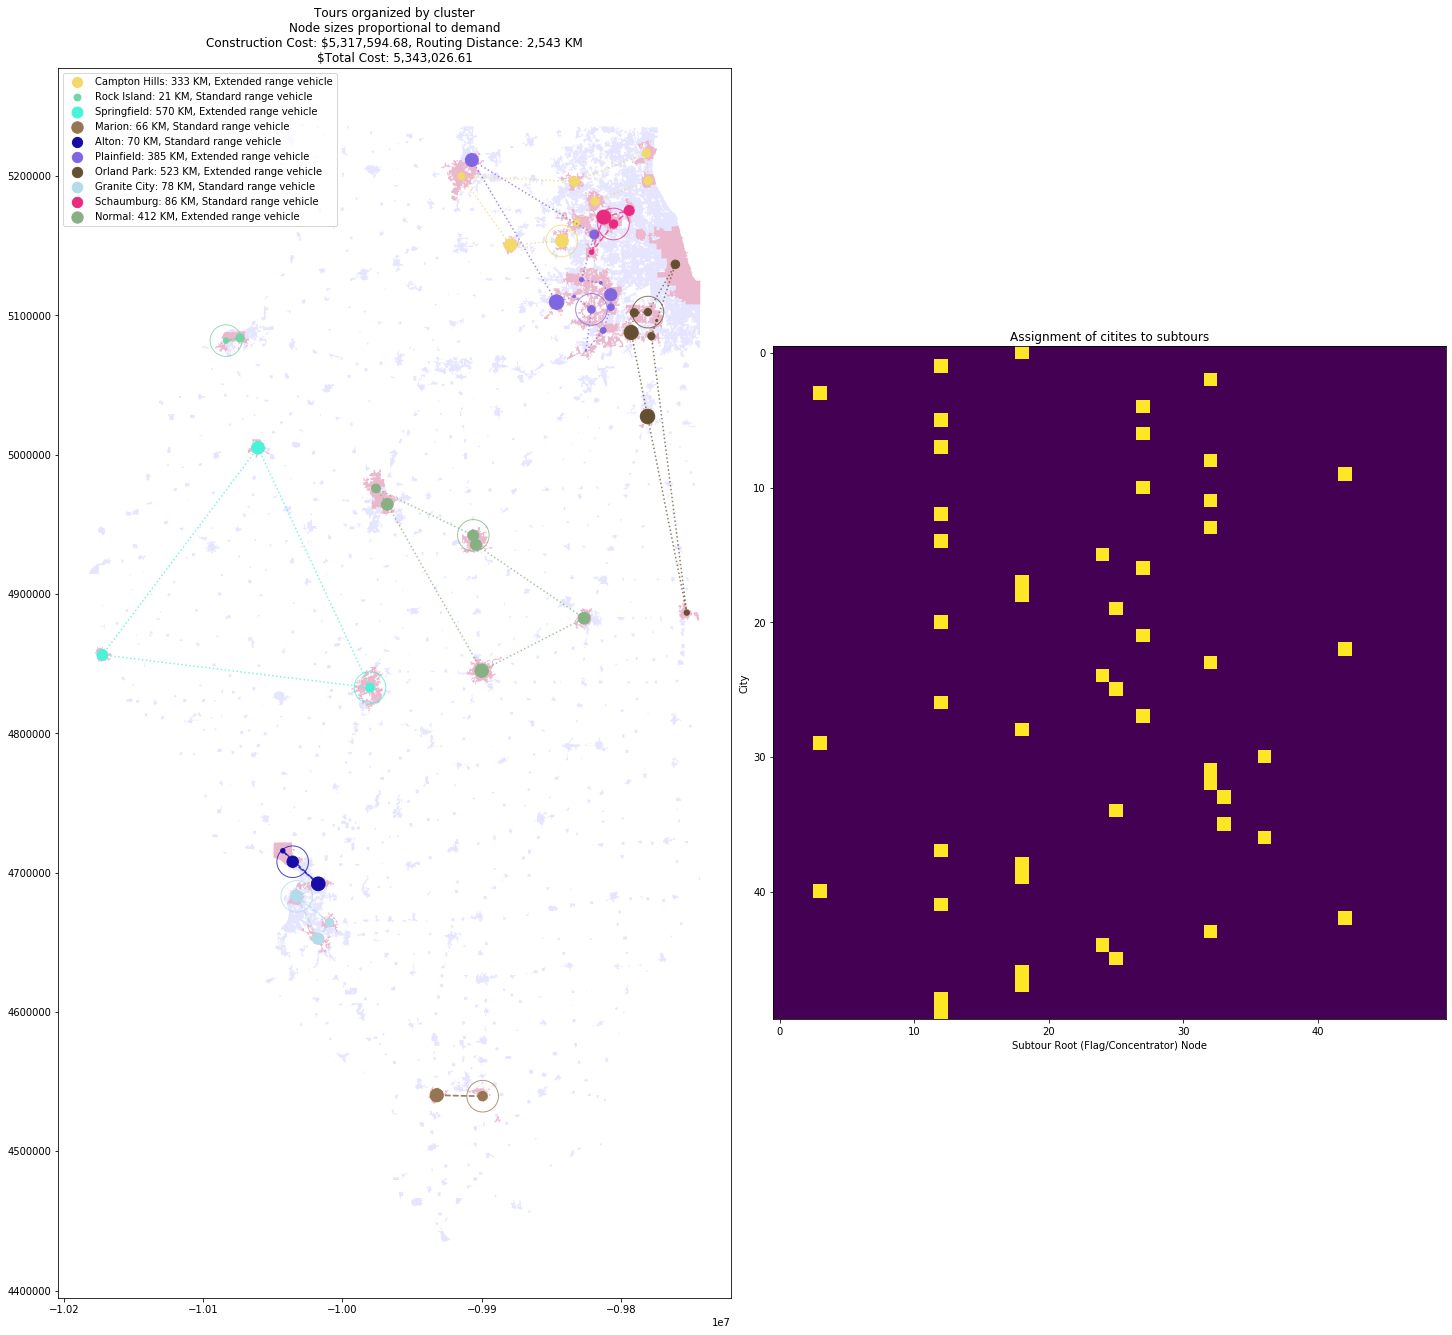

         6475065 function calls (6412085 primitive calls) in 130.201 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  117.594  117.594  117.594  117.594 {built-in method ortools.linear_solver._pywraplp.Solver_Solve}
      528    2.486    0.005    2.589    0.005 {method 'draw_path_collection' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
        1    0.476    0.476    1.240    1.240 <ipython-input-36-b849eecaab9b>:21(<listcomp>)
   535085    0.287    0.000    0.548    0.000 {built-in method builtins.isinstance}
    17600    0.257    0.000    0.365    0.000 linear_solver_natural_api.py:119(__rmul__)
508075/508045    0.225    0.000    0.461    0.000 {built-in method builtins.getattr}
      918    0.217    0.000    0.217    0.000 {method 'set_text' of 'matplotlib.ft2font.FT2Font' objects}
68973/68415    0.211    0.000    0.607    0.000 {built-in method numpy.array}
   170100    0.179    0.000    0.345    

In [42]:
%prun solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[40000,80000],alpha=0.01,fractionTruckRangeAllowed=0.65,maxTimeLimit=2*60*1000)

Route for vehicle 0:
 19 -> 34 -> 31 -> 19
Route distance: 85.498 km

Route for vehicle 0:
 33 -> 35 -> 33
Route distance: 20.614 km

Route for vehicle 0:
 4 -> 21 -> 40 -> 29 -> 4
Route distance: 521.061 km

Route for vehicle 0:
 30 -> 36 -> 30
Route distance: 65.956 km

Route for vehicle 0:
 2 -> 37 -> 23 -> 13 -> 11 -> 8 -> 41 -> 45 -> 32 -> 2
Route distance: 352.417 km

Route for vehicle 0:
 0 -> 47 -> 26 -> 12 -> 49 -> 20 -> 43 -> 5 -> 7 -> 0
Route distance: 415.202 km

Route for vehicle 0:
 6 -> 16 -> 28 -> 27 -> 10 -> 6
Route distance: 416.773 km

Route for vehicle 0:
 1 -> 48 -> 39 -> 46 -> 38 -> 18 -> 17 -> 14 -> 1
Route distance: 146.998 km

Route for vehicle 0:
 25 -> 25
Route distance: 0.0 km

Route for vehicle 0:
 3 -> 9 -> 42 -> 24 -> 15 -> 44 -> 22 -> 3
Route distance: 391.083 km

 

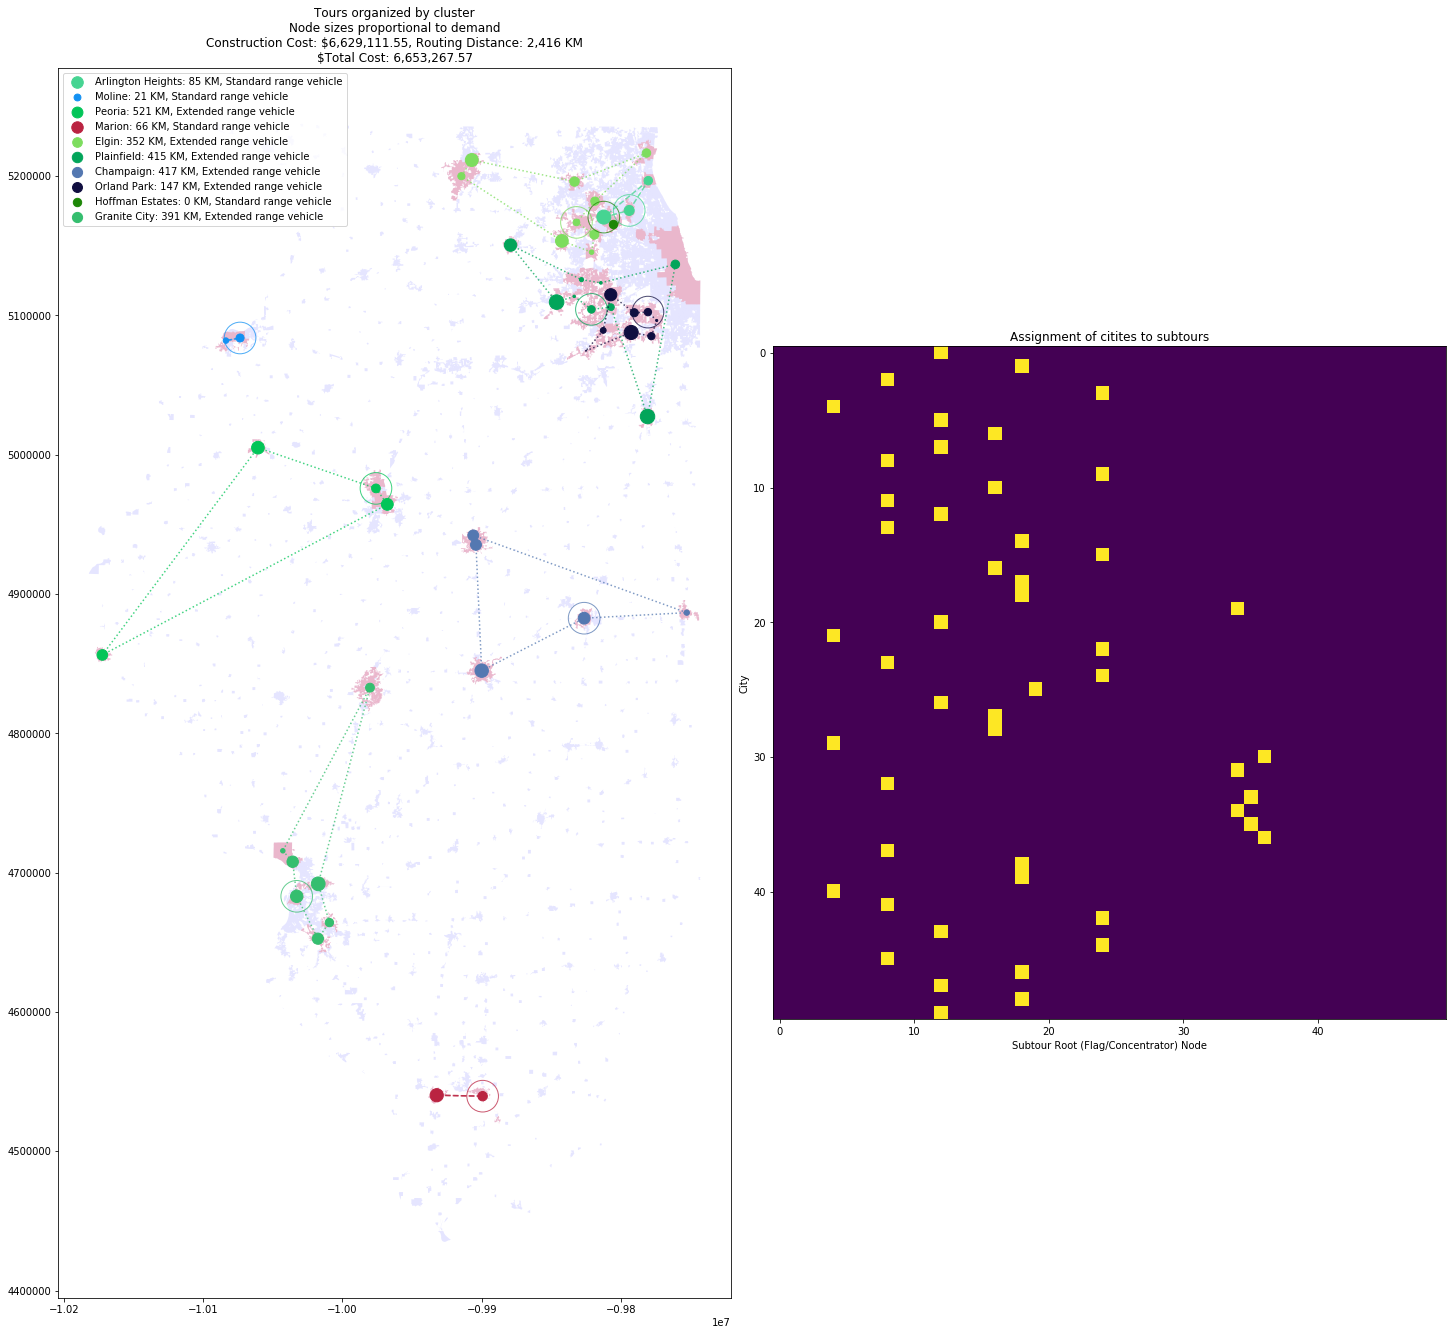

         6474128 function calls (6411158 primitive calls) in 128.485 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  117.585  117.585  117.585  117.585 {built-in method ortools.linear_solver._pywraplp.Solver_Solve}
      522    2.088    0.004    2.176    0.004 {method 'draw_path_collection' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
        1    0.500    0.500    1.177    1.177 <ipython-input-36-b849eecaab9b>:21(<listcomp>)
507983/507953    0.254    0.000    0.470    0.000 {built-in method builtins.getattr}
   535004    0.240    0.000    0.481    0.000 {built-in method builtins.isinstance}
   170100    0.204    0.000    0.400    0.000 pywraplp.py:419(__getattr__)
      918    0.186    0.000    0.186    0.000 {method 'set_text' of 'matplotlib.ft2font.FT2Font' objects}
68985/68427    0.178    0.000    0.538    0.000 {built-in method numpy.array}
     5865    0.138    0.000    0.243    0.000 coords.p

In [41]:
%prun solveAndPlot(illinoisCities,M=10,Rvz=[100000,600000],truckCapacityZ=[40000,80000],alpha=0.01,fractionTruckRangeAllowed=0.6,maxTimeLimit=2*60*1000)